In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cleaned-dataset/cleaned_data/Powdery Mildew/IMG_20211107_125226 (Custom).jpg
/kaggle/input/cleaned-dataset/cleaned_data/Powdery Mildew/IMG_20211107_125656 (Custom).jpg
/kaggle/input/cleaned-dataset/cleaned_data/Powdery Mildew/IMG_20211107_125157 (Custom).jpg
/kaggle/input/cleaned-dataset/cleaned_data/Powdery Mildew/20211109_121933 (Custom).jpg
/kaggle/input/cleaned-dataset/cleaned_data/Powdery Mildew/IMG_20211107_125339 (Custom).jpg
/kaggle/input/cleaned-dataset/cleaned_data/Powdery Mildew/20211109_122151(0) (Custom).jpg
/kaggle/input/cleaned-dataset/cleaned_data/Powdery Mildew/20211109_122241 (Custom).jpg
/kaggle/input/cleaned-dataset/cleaned_data/Powdery Mildew/20211109_121859 (Custom).jpg
/kaggle/input/cleaned-dataset/cleaned_data/Powdery Mildew/20211109_121803 (Custom).jpg
/kaggle/input/cleaned-dataset/cleaned_data/Powdery Mildew/20211109_121506 (Custom).jpg
/kaggle/input/cleaned-dataset/cleaned_data/Powdery Mildew/20211109_121825 (Custom).jpg
/kaggle/input/cleaned-da

Loading data...
Checking folder: /kaggle/input/cleaned-dataset/cleaned_data/Anthracnose
Checking folder: /kaggle/input/cleaned-dataset/cleaned_data/Bacterial Canker
Checking folder: /kaggle/input/cleaned-dataset/cleaned_data/Gall Midge
Checking folder: /kaggle/input/cleaned-dataset/cleaned_data/Healthy
Checking folder: /kaggle/input/cleaned-dataset/cleaned_data/Powdery Mildew
Checking folder: /kaggle/input/cleaned-dataset/cleaned_data/Sooty Mould
Building model...
Training model...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 188ms/step - accuracy: 0.1911 - loss: 2.3521 - val_accuracy: 0.3472 - val_loss: 1.7621
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 155ms/step - accuracy: 0.3293 - loss: 1.6510 - val_accuracy: 0.5028 - val_loss: 1.3931
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 155ms/step - accuracy: 0.4590 - loss: 1.3528 - val_accuracy: 0.5972 - val_loss: 1.1007
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 155ms/step - accuracy: 0.5398 - loss: 1.1181 - val_accuracy: 0.5833 - val_loss: 0.9683
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 155ms/step - accuracy: 0.6737 - loss: 0.8660 - val_accuracy: 0.6556 - val_loss: 1.0037
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 155ms/step - accuracy: 0.6904 - loss: 0.7814 - val_accuracy: 0.7944 - val_loss: 0.5706
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.7488 - loss: 0.7026 - val_accuracy: 0.8111 - val_loss: 0.5463
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 156ms/step - accuracy: 0.8102 - loss: 0.5893 - val_accuracy: 0.850

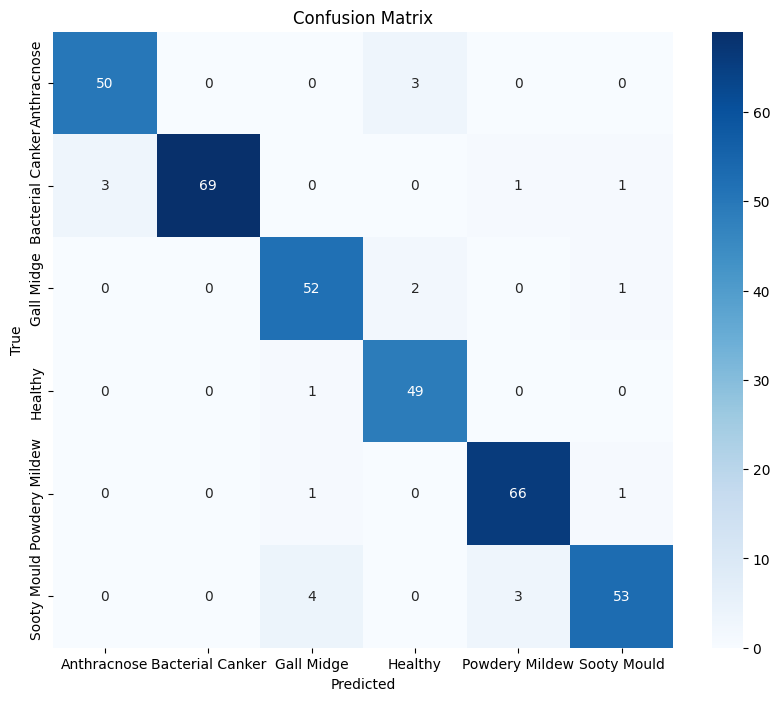

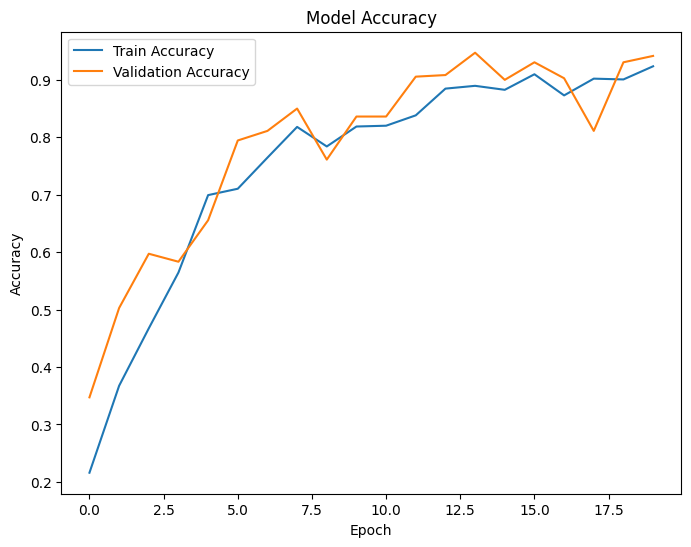

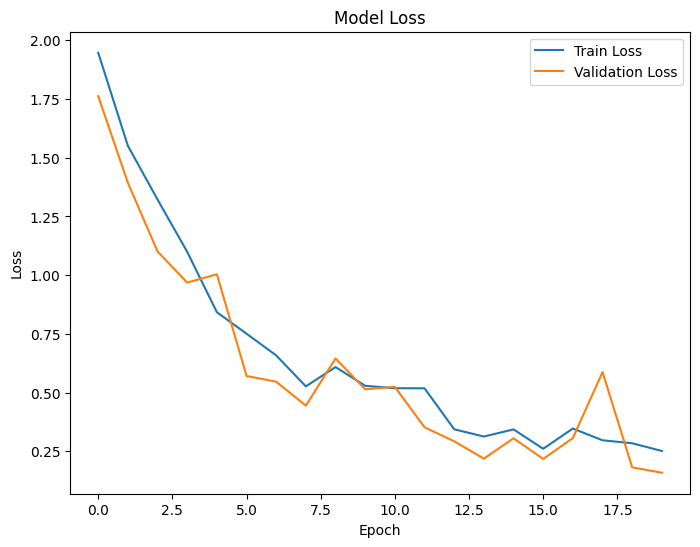

In [13]:
# CODING FOR THE MODEL DEVELOPMENT AND PREDICTION

import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Constants
IMG_SIZE = 240 # Resize all images to 128x128
BATCH_SIZE = 16  # Batch size for training
DATASET_PATH = "/kaggle/input/cleaned-dataset/cleaned_data"  # Path to your dataset folder
CLASSES = [
    "Anthracnose", "Bacterial Canker","Gall Midge", "Healthy", "Powdery Mildew", "Sooty Mould"
]

# 1. Load and Preprocess Dataset
def load_and_preprocess_data(dataset_path, img_size, classes):
    data = []
    labels = []
    for label_idx, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        print(f"Checking folder: {class_path}")
        if not os.path.exists(class_path):
            raise FileNotFoundError(f"Folder not found: {class_path}")
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (img_size, img_size))
                data.append(img)
                labels.append(label_idx)
            else:
                print(f"Failed to load image: {img_path}")
    return np.array(data), np.array(labels)

print("Loading data...")
X, y = load_and_preprocess_data(DATASET_PATH, IMG_SIZE, CLASSES)
X = X / 255.0  # Normalize pixel values
y = to_categorical(y, num_classes=len(CLASSES))

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Augment Data
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)

# 3. Build CNN Model
def build_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

print("Building model...")
model = build_cnn((IMG_SIZE, IMG_SIZE, 3), len(CLASSES))

# 4. Train the Model
print("Training model...")
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_test, y_test),
    epochs=20
)

# Save the trained model
model.save("leaf_disease_model.h5")

# 5. Evaluate the Model
print("Evaluating model...")
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification Report
print("Classification Report:")
report = classification_report(y_true, y_pred_classes, target_names=CLASSES)
print(report)

# Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 6. Plot Accuracy and Loss
def plot_training_history(history):
    # Accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Loss
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_history(history)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training CNN...
Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.1946 - loss: 1.8382 - val_accuracy: 0.1389 - val_loss: 1.7997
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.2895 - loss: 1.6857 - val_accuracy: 0.4167 - val_loss: 1.4004
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.4757 - loss: 1.3000 - val_accuracy: 0.6583 - val_loss: 1.0778
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.5180 - loss: 1.1399 - val_accuracy: 0.7472 - val_loss: 0.7213
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.6409 - loss: 0.9264 - val_accuracy: 0.6278 - val_loss: 0.9799
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.6743 - loss: 0.8547 - val_accuracy: 0.8139 - val_loss: 0.5698
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.7084 - loss: 0.7638 - val_accuracy: 0.8389 - val_loss: 0.4928
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.7646 - loss: 0.6145 - val_acc

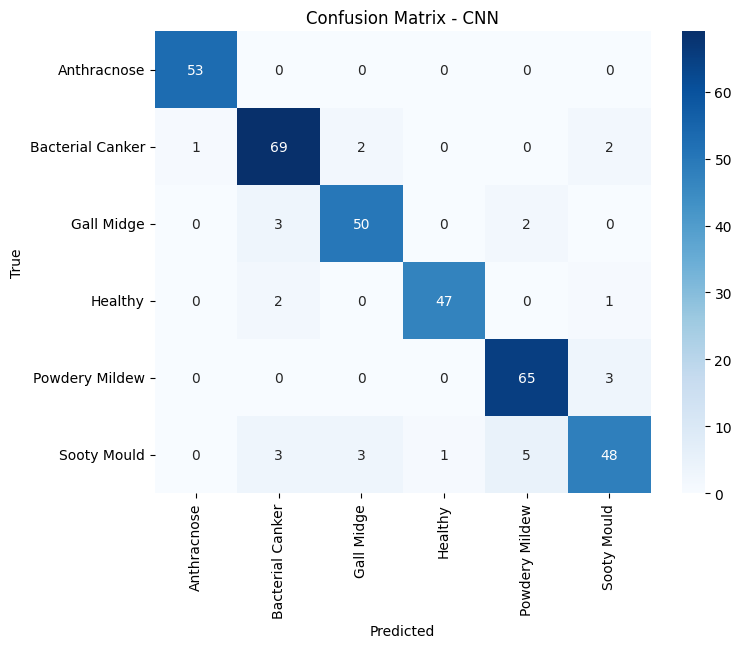

Training ResNet50...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 207ms/step - accuracy: 0.1717 - loss: 1.9010 - val_accuracy: 0.2056 - val_loss: 1.7758
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.1862 - loss: 1.7912 - val_accuracy: 0.1389 - val_loss: 1.7768
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.1997 - loss: 1.7741 - val_accuracy: 0.2139 - val_loss: 1.7568
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.2523 - loss: 1.7522 - val_accuracy: 0.1750 - val_loss: 1.7558
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.2523 - loss: 1.7438 - val_accuracy: 0.1944 - val_loss: 1.7473
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.2550 - loss: 1.7209 - val_accuracy: 0.2056 - val_loss: 1.7199
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.2761 - loss: 1.6946 - val_accuracy: 0.2194 - val_loss: 1.7154
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.2721 - loss: 1.6955 - val_accuracy: 0.3056 - val

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


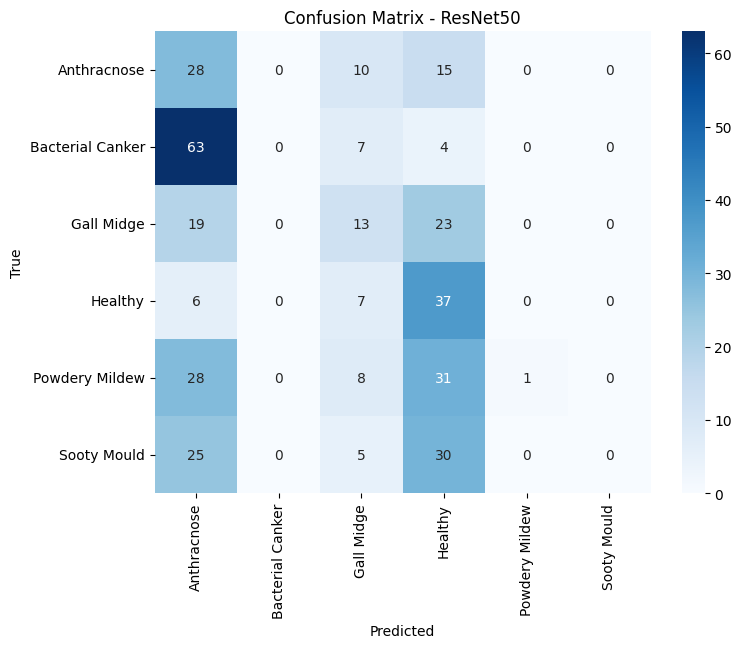

Training VGG16...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.2651 - loss: 1.8085 - val_accuracy: 0.5583 - val_loss: 1.3164
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.5083 - loss: 1.2982 - val_accuracy: 0.7889 - val_loss: 0.9435
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.6716 - loss: 1.0001 - val_accuracy: 0.7694 - val_loss: 0.7566
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.7314 - loss: 0.8223 - val_accuracy: 0.8083 - val_loss: 0.6494
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.7520 - loss: 0.7203 - val_accuracy: 0.8444 - val_loss: 0.5488
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.7681 - loss: 0.6525 - val_accuracy: 0.8639 - val_loss: 0.4925
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.8077 - loss: 0.6051 - val_accuracy: 0.8583 - val_loss: 0.4749
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.8090 - loss: 0.5724 - val_accuracy: 0.8694 - val_

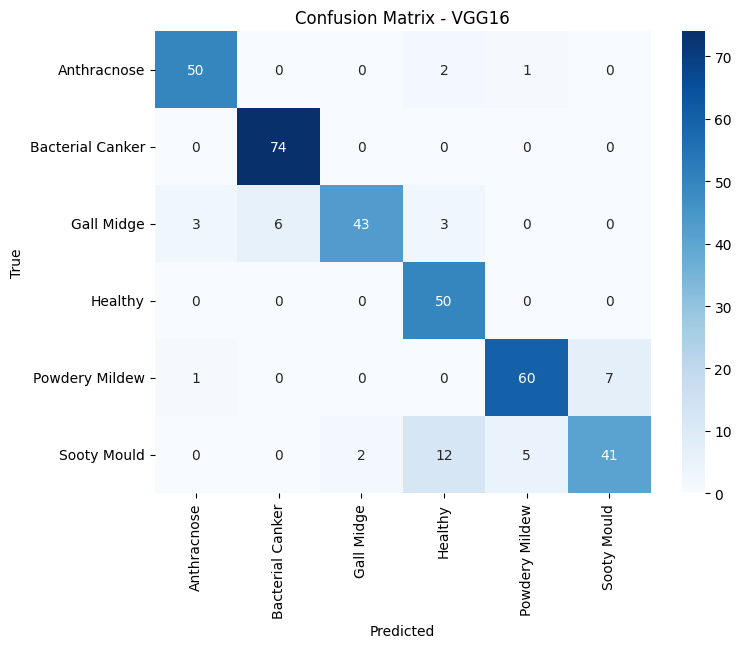

Training MobileNetV2...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 183ms/step - accuracy: 0.4858 - loss: 1.3691 - val_accuracy: 0.8500 - val_loss: 0.4186
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.8358 - loss: 0.4815 - val_accuracy: 0.8944 - val_loss: 0.2728
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.8841 - loss: 0.3284 - val_accuracy: 0.9444 - val_loss: 0.1483
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.9117 - loss: 0.2412 - val_accuracy: 0.9583 - val_loss: 0.1277
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.9303 - loss: 0.2176 - val_accuracy: 0.9694 - val_loss: 0.1036
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.9417 - loss: 0.1774 - val_accuracy: 0.9722 - val_loss: 0.0867
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.9607 - loss: 0.1340 - val_accuracy: 0.9694 - val_loss: 0.1027
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.9426 - loss: 0.1776 - val_accuracy: 0.9750 - val_loss: 

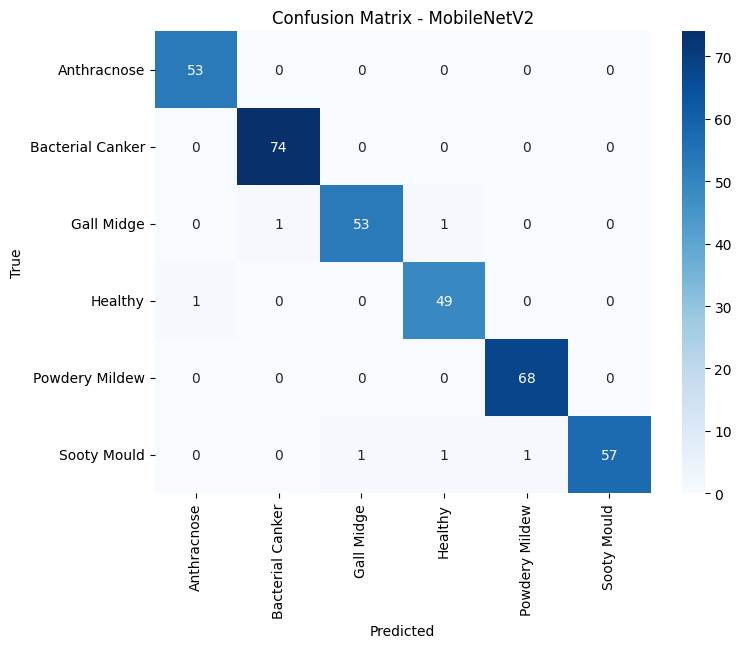

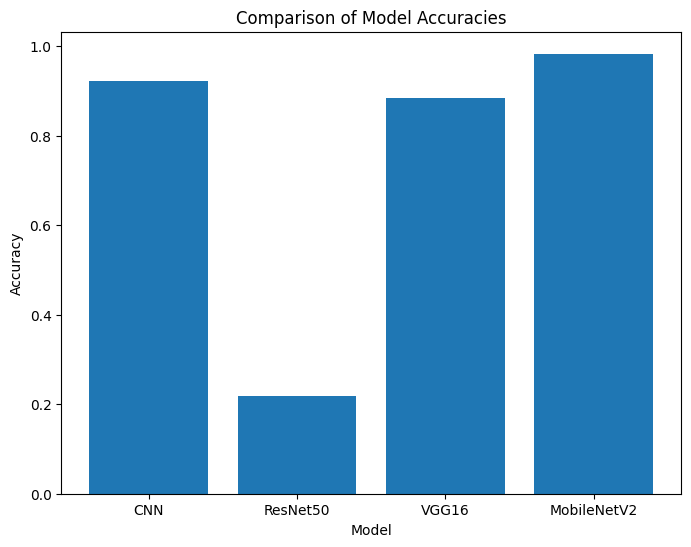

In [15]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical

# Constants
IMG_SIZE = 128
BATCH_SIZE = 32
DATASET_PATH = "/kaggle/input/cleaned-dataset/cleaned_data"
CLASSES = ["Anthracnose", "Bacterial Canker",
           "Gall Midge", "Healthy", "Powdery Mildew", "Sooty Mould"]

# 1. Load and Preprocess Dataset
def load_and_preprocess_data(dataset_path, img_size, classes):
    data, labels = [], []
    for label_idx, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (img_size, img_size))
                data.append(img)
                labels.append(label_idx)
    return np.array(data), np.array(labels)

X, y = load_and_preprocess_data(DATASET_PATH, IMG_SIZE, CLASSES)
X = X / 255.0  # Normalize
y = to_categorical(y, num_classes=len(CLASSES))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)
datagen.fit(X_train)

# 2. Build Models
def build_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_pretrained_model(base_model, num_classes):
    base_model.trainable = False  # Freeze the convolutional base
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = (IMG_SIZE, IMG_SIZE, 3)
models = {
    "CNN": build_cnn(input_shape, len(CLASSES)),
    "ResNet50": build_pretrained_model(ResNet50(weights='imagenet', include_top=False, input_shape=input_shape), len(CLASSES)),
    "VGG16": build_pretrained_model(VGG16(weights='imagenet', include_top=False, input_shape=input_shape), len(CLASSES)),
    "MobileNetV2": build_pretrained_model(MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape), len(CLASSES))
}

# 3. Train and Evaluate Models
results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE), validation_data=(X_test, y_test), epochs=10)
    
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(y_test, axis=1)
    accuracy = np.mean(y_pred == y_true)
    results[model_name] = accuracy
    
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_true, y_pred, target_names=CLASSES))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES, cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
# Compare Model Performance
plt.figure(figsize=(8, 6))
plt.bar(results.keys(), results.values())
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracies")
plt.show()


In [17]:


for model_name, model in models.items():
    print(f"Training {model_name}...")
    history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE), validation_data=(X_test, y_test), epochs=10)
    model.save(f"{model_name}_model.h5")
    print(f"Saved {model_name} model.")


Training CNN...
Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.3216 - loss: 1.6088 - val_accuracy: 0.5139 - val_loss: 1.4369
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.4440 - loss: 1.4137 - val_accuracy: 0.5111 - val_loss: 1.2319
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.4953 - loss: 1.2882 - val_accuracy: 0.6667 - val_loss: 0.8968
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.6225 - loss: 0.9807 - val_accuracy: 0.4417 - val_loss: 1.3102
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.4970 - loss: 1.2987 - val_accuracy: 0.7806 - val_loss: 0.6016
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.7019 - loss: 0.7864 - val_accuracy: 0.7944 - val_loss: 0.5696
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.7606 - loss: 0.6084 - val_accuracy: 0.8778 - val_loss: 0.3609
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.8028 - loss: 0.5092 - val_acc